# Kimberly Cui, Stats 140XP Project – Analysis (Paper)
### Measuring the Predictive Relationship Between Investor Sentiment and Next-Day Bitcoin Returns

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.dates as mdates

df = pd.read_csv("../data/fnp-btc_data.csv")
# make sure columns are real! 
df.columns

# make sure dates are real! preparation for time series analysis 
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# construct log returns (dependent variable) 
# For each day, compute how much the price changes (in log terms) from today to tomorrow. 

df["log_price"] = np.log(df["Close"])
df["return_t1"] = df["log_price"].shift(-1) - df["log_price"]
df = df.dropna()

df.head()

,Date,sentiment,sentiment_label,Open,High,Low,Close,Volume,log_price,return_t1
0,2018-02-01,30,Fear,10269.843887,10332.946065,8700.332595,9171.249369,4.557095e+09,9.123829,-0.044927
1,2018-02-02,15,Extreme Fear,9118.231270,9127.685961,7588.546351,8768.328115,5.511338e+09,9.078901,0.047108
2,2018-02-03,40,Fear,8763.536968,9417.790992,8173.729947,9191.270888,4.856473e+09,9.126009,-0.107243
3,2018-02-04,24,Extreme Fear,9198.067914,9351.571884,7986.357859,8256.583798,3.993494e+09,9.018766,-0.178626
4,2018-02-05,11,Extreme Fear,8215.505812,8343.181452,6665.107706,6905.959543,4.795002e+09,8.840140,0.117749


In [111]:
# Section 4.1: Descriptive Statistics

desc_stats = df[["return_t1", "sentiment"]].describe().T

desc_stats["skewness"] = df[["return_t1", "sentiment"]].skew()
desc_stats["kurtosis"] = df[["return_t1", "sentiment"]].kurtosis()

desc_stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
return_t1,2847.0,0.000781,0.034142,-0.518084,-0.01337,0.000758,0.015105,0.172829,-1.276491,21.450607
sentiment,2847.0,47.516333,21.637230,5.000000,28.00000,47.000000,66.000000,95.000000,0.139376,-1.023556


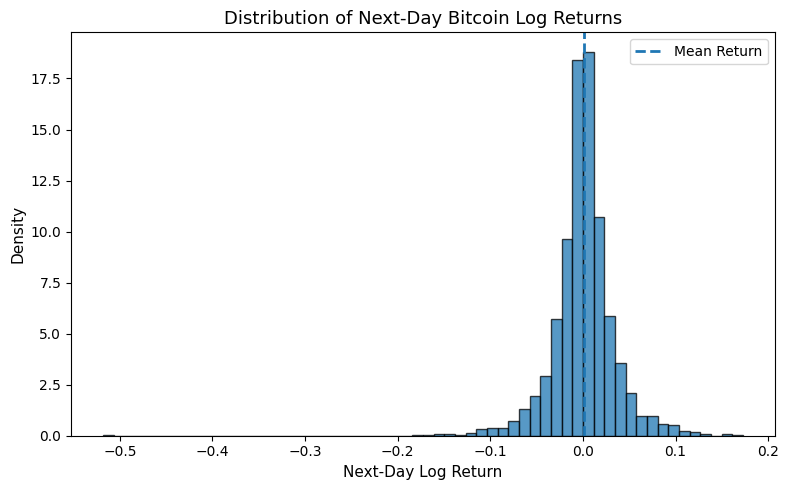

In [112]:
plt.figure(figsize=(8,5))

plt.hist(
    df["return_t1"],
    bins=60,
    density=True,
    alpha=0.75,
    edgecolor="black"
)

plt.axvline(
    df["return_t1"].mean(),
    linestyle="--",
    linewidth=2,
    label="Mean Return"
)

plt.title("Distribution of Next-Day Bitcoin Log Returns", fontsize=13)
plt.xlabel("Next-Day Log Return", fontsize=11)
plt.ylabel("Density", fontsize=11)

plt.legend()
plt.tight_layout()
plt.show()


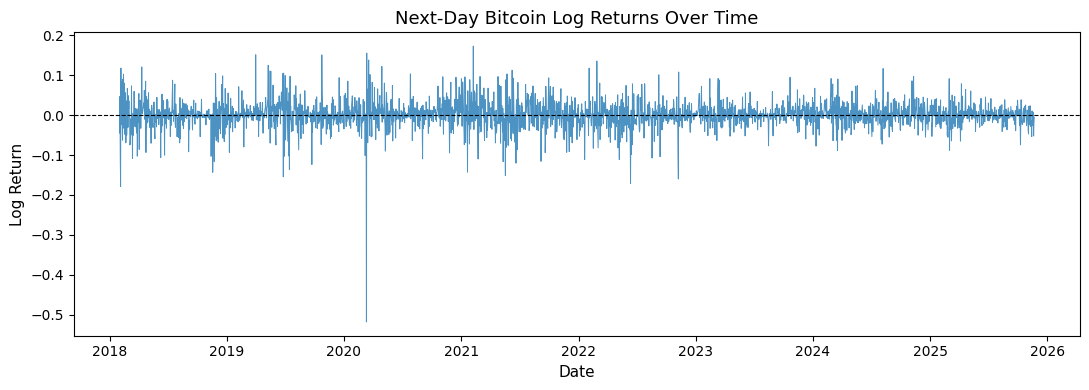

In [113]:
# Section 4.3: Returns Over Time

plt.figure(figsize=(11, 4))

plt.plot(
    df["Date"],
    df["return_t1"],
    linewidth=0.7,
    alpha=0.8
)

plt.axhline(0, color="black", linewidth=0.8, linestyle="--")

plt.title("Next-Day Bitcoin Log Returns Over Time", fontsize=13)
plt.xlabel("Date", fontsize=11)
plt.ylabel("Log Return", fontsize=11)

plt.tight_layout()
plt.show()


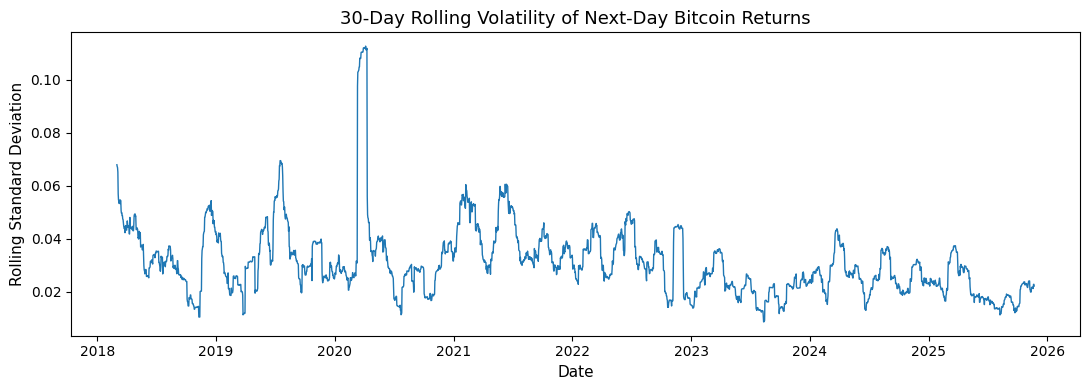

In [114]:
# Rolling Volatility

df["rolling_vol"] = df["return_t1"].rolling(30).std()

plt.figure(figsize=(11, 4))

plt.plot(
    df["Date"],
    df["rolling_vol"],
    linewidth=1.0
)

plt.title("30-Day Rolling Volatility of Next-Day Bitcoin Returns", fontsize=13)
plt.xlabel("Date", fontsize=11)
plt.ylabel("Rolling Standard Deviation", fontsize=11)

plt.tight_layout()
plt.show()


In [115]:
fear_greed_cmap = LinearSegmentedColormap.from_list(
    "fear_greed",
    ["#7f0000", "#D3D3D3", "#1a9850"]  # red → neutral → green
)

sentiment_norm = Normalize(vmin=0, vmax=100)


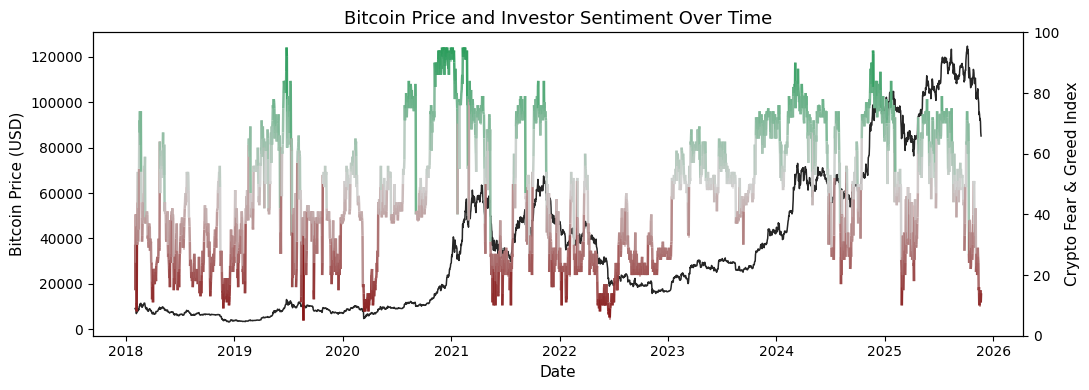

In [116]:
# =========================
# Section 4.4: Price + Color-Changing Sentiment Line
# =========================

fig, ax1 = plt.subplots(figsize=(11, 4))

# --- Bitcoin price (left axis)
ax1.plot(
    df["Date"],
    df["Close"],
    color="black",
    linewidth=1.1,
    alpha=0.85
)
ax1.set_xlabel("Date", fontsize=11)
ax1.set_ylabel("Bitcoin Price (USD)", fontsize=11)

# --- Prepare sentiment line (RIGHT axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Crypto Fear & Greed Index", fontsize=11)
ax2.set_ylim(0, 100)

# Convert dates to numeric for LineCollection
x = mdates.date2num(df["Date"].values)
y = df["sentiment"].values

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(
    segments,
    cmap=fear_greed_cmap,
    norm=sentiment_norm,
    linewidth=1.8,
    alpha=0.95
)
lc.set_array(y)

ax2.add_collection(lc)

plt.title("Bitcoin Price and Investor Sentiment Over Time", fontsize=13)
plt.tight_layout()
plt.show()


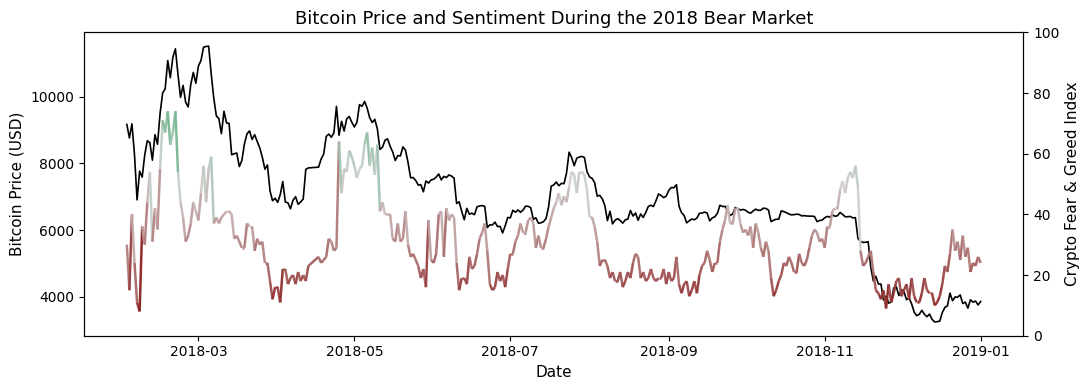

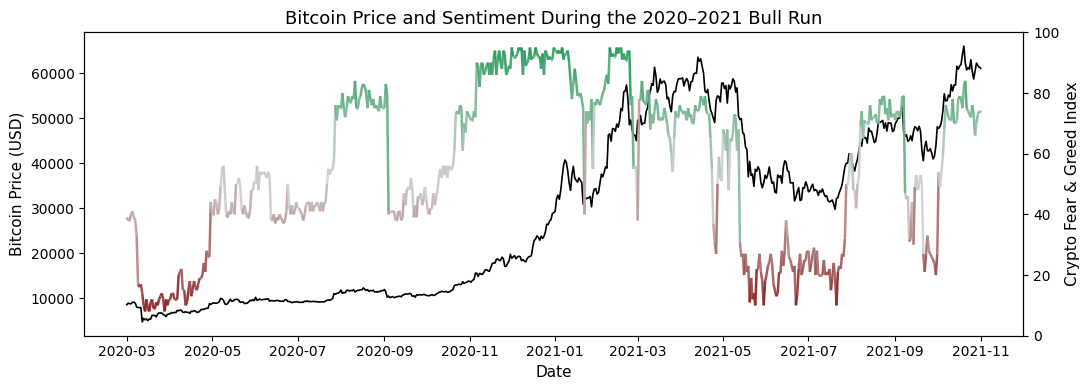

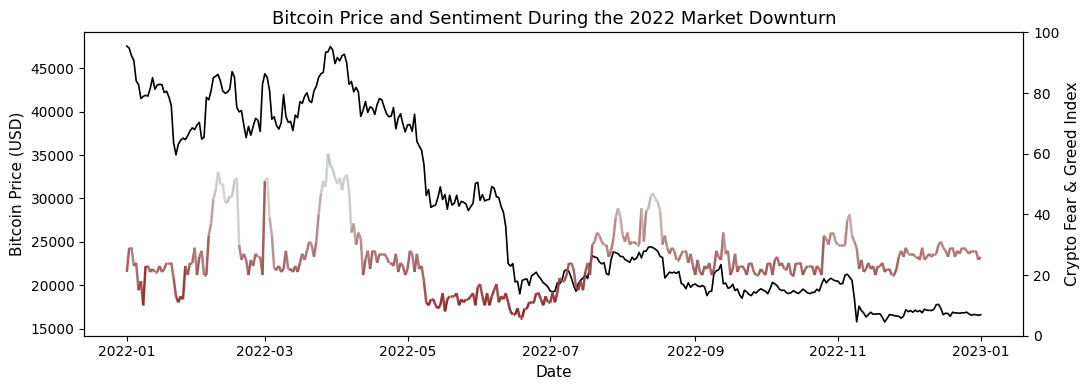

In [117]:
def plot_price_sentiment_window(start, end, title):
    subset = df[(df["Date"] >= start) & (df["Date"] <= end)]

    fig, ax1 = plt.subplots(figsize=(11, 4))

    # --- Bitcoin price
    ax1.plot(
        subset["Date"],
        subset["Close"],
        color="black",
        linewidth=1.2
    )
    ax1.set_ylabel("Bitcoin Price (USD)", fontsize=11)
    ax1.set_xlabel("Date", fontsize=11)

    # --- Sentiment axis
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 100)
    ax2.set_ylabel("Crypto Fear & Greed Index", fontsize=11)

    # Convert dates properly
    x = mdates.date2num(subset["Date"].values)
    y = subset["sentiment"].values

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(
        segments,
        cmap=fear_greed_cmap,
        norm=sentiment_norm,
        linewidth=1.8,
        alpha=0.95
    )
    lc.set_array(y)

    ax2.add_collection(lc)

    plt.title(title, fontsize=13)
    plt.tight_layout()
    plt.show()


# Example 1: 2018 Bear Market
plot_price_sentiment_window(
    start="2018-01-01",
    end="2019-01-01",
    title="Bitcoin Price and Sentiment During the 2018 Bear Market"
)

# Example 2: 2020–2021 Bull Run
plot_price_sentiment_window(
    start="2020-03-01",
    end="2021-11-01",
    title="Bitcoin Price and Sentiment During the 2020–2021 Bull Run"
)

# Example 3: 2022 Bear Market
plot_price_sentiment_window(
    start="2022-01-01",
    end="2023-01-01",
    title="Bitcoin Price and Sentiment During the 2022 Market Downturn"
)



In [118]:
df.groupby("sentiment_label")["return_t1"].mean()


sentiment_label
Extreme Fear     0.000497
Extreme Greed    0.003138
Fear            -0.000892
Greed            0.002568
Neutral         -0.000611
Name: return_t1, dtype: float64

In [119]:
# Appendix 4.5: Returns by Sentiment Regime

sentiment_table = (
    df.groupby("sentiment_label")["return_t1"]
      .agg(
          count="count",
          mean_return="mean",
          std_return="std"
      )
      .reindex([
          "Extreme Fear",
          "Fear",
          "Neutral",
          "Greed",
          "Extreme Greed"
      ])
)

sentiment_table = sentiment_table.round({
    "mean_return": 5,
    "std_return": 5
})

sentiment_table.rename(columns={
    "count": "Number of Days",
    "mean_return": "Mean Next-Day Log Return",
    "std_return": "Std. Dev. of Next-Day Return"
}, inplace=True)

sentiment_table


,Number of Days,Mean Next-Day Log Return,Std. Dev. of Next-Day Return
sentiment_label,,,
Extreme Fear,570,0.00050,0.04503
Fear,819,-0.00089,0.03151
Neutral,388,-0.00061,0.02488
Greed,789,0.00257,0.02831
Extreme Greed,281,0.00314,0.04111


In [120]:
# Section 5.1, baseline model 

import statsmodels.api as sm

# dependent variable
y = df["return_t1"]

# independent variable (sentiment at time t)
X = sm.add_constant(df["sentiment"])

# baseline OLS regression
baseline_ols = sm.OLS(y, X).fit()

print(baseline_ols.summary())


                            OLS Regression Results                            
Dep. Variable:              return_t1   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.366
Date:                Mon, 15 Dec 2025   Prob (F-statistic):             0.0368
Time:                        21:38:51   Log-Likelihood:                 5578.0
No. Observations:                2847   AIC:                        -1.115e+04
Df Residuals:                    2845   BIC:                        -1.114e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -1.396      0.1

In [121]:
baseline_ols.resid.kurtosis()


21.238700641132656

In [122]:
# Section 5.3: HAC / Newey–West standard errors

hac_results = baseline_ols.get_robustcov_results(
    cov_type="HAC",
    maxlags=5
)

print(hac_results.summary())


                            OLS Regression Results                            
Dep. Variable:              return_t1   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.503
Date:                Mon, 15 Dec 2025   Prob (F-statistic):             0.0613
Time:                        21:38:52   Log-Likelihood:                 5578.0
No. Observations:                2847   AIC:                        -1.115e+04
Df Residuals:                    2845   BIC:                        -1.114e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -1.220      0.2

In [123]:
import statsmodels.api as sm

# lagged return control
df["return_t"] = df["return_t1"].shift(1)
df_lag = df.dropna()

y = df_lag["return_t1"]
X = sm.add_constant(df_lag[["sentiment", "return_t"]])

ols_lag = sm.OLS(y, X).fit()

# HAC standard errors (same lag choice as before)
hac_lag = ols_lag.get_robustcov_results(cov_type="HAC", maxlags=5)

print(hac_lag.summary())


                            OLS Regression Results                            
Dep. Variable:              return_t1   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.955
Date:                Mon, 15 Dec 2025   Prob (F-statistic):             0.0523
Time:                        21:38:52   Log-Likelihood:                 5569.7
No. Observations:                2818   AIC:                        -1.113e+04
Df Residuals:                    2815   BIC:                        -1.112e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.002     -1.373      0.1